# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 2. Методы нахождения оценок
### Дедлайн --- 24.10.2023 23:59

Выполняйте задания прямо в ноутбуке. Пожалуйста, не стирайте условия задач.

- Информация о выполнении и курсе в целом есть в чате https://t.me/+IHdLycZDD5g5MDQy.
- По вопросам об условиях задач, требованиям можно писать в чат или https://t.me/vitalii_kondratiuk .
- По организационным вопросам https://t.me/d_pavlov_p

В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека scipy.stats. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook и его pdf-версия с:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается в 10 баллов, если не оговорено иного.

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте". Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить гистограмму или эмпирическую функцию распределения, и сделать выводы о распределении оценок.

Как мы знаем по теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует.

Для красоты графиков можно (и приветствуется) вместо гистограммы использовать ядерную оценку плотности (kernel density estimator): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

Загрузим все необходимые датасеты. Если что-то пошло не так, то просто скачайте файлы по ссылке вручную.

In [1]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
!gdown https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs

zsh:1: /opt/homebrew/bin/pip: bad interpreter: /opt/homebrew/opt/python@3.10/bin/python3.10: no such file or directory
zsh:1: no matches found: https://drive.google.com/uc?id=1fMQ0H-_E4U25XHB2SH7ryoZPLG2MHlLQ
zsh:1: no matches found: https://drive.google.com/uc?id=1cJywRii7wBZa0B2uAvvu56JFCLPnlOSs


In [2]:
import pandas as pd
import numpy as np
from scipy import stats as sps
import warnings

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)
warnings.filterwarnings('ignore')
%matplotlib inline

**Условие задания**: Великая Ордалия уже почти готова к путешествию, однако враги империи проникли в замок и уничтожили все формулы с оценками из Домашнего задания 1. Можно попытаться восстановить их по памяти, но не лучше ли взамен старых оценок изобрести новые? Помимо этого за две тысячи лет (прошедших с момента первой ордалии до наших дней) точечные оценки значительно устарели и уже не способны отражать реальную суть вещей, поэтому Вам будет предложено попробовать на практике два других подхода: интервальные оценки и байесовские оценки.

В этой практике Вам предложено реализовать несколько подходов к построению оценок и понять, когда какой подход применять.

**Дисклеймер**:
В задачах будет разбиение на пункты, но оцениваться задача будет **целиком**. Можете считать, что выполнение всех пунктов вместе с отсутствием замечаний по полноте анализа/эффективности кода/информативности графиков/т.д. приносит полный балл.

## Задача 1

Для постоянного слежения за большой армией колдуны-гностики создали магическое устройство для наблюдения с неба.

На высоте в 1 милю от центра армии (на Земле) закреплено устройство,
которое периодически излучает лучи на поверхность Земли (считайте,
что поверхность Земли представляет из себя прямую). Пусть $l$ —
перпендикуляр к поверхности Земли, опущенный из точки, в которой
закреплено устройство. Угол к прямой $l$ (под которым происходит
излучение) устройство выбирает случайно из равномерного
распределения на отрезке $\left(-\frac{\pi}{2}, \frac{\pi}{2}\right)$ (все выборы
осуществляются независимо). В этих предположениях точки пересечения
с поверхностью имеют распределение Коши с плотностью $p(x) =
\frac{1}{\pi(1 + (x-x_0)^2)}.$ Неизвестный параметр сдвига $x_0$
соответствует проекции точки расположения устройства на поверхность
Земли (направление оси и начало координат на поверхности Земли
выбраны заранее некоторым образом независимо от расположения
устройства). В файле `Cauchy.csv` находятся координаты точек
пересечения лучей с поверхностью Земли.

**Нам предстоит построить и изучить оценку максимального правдоподобия (ОМП)**

In [3]:
cauchy_sample = pd.read_csv("Cauchy.csv")["sample"].values

1. Выпишите теоретическое правдоподобие выборки из распределения Коши и его логарифм. Можно ли найти максимум аналитически?

Решение:
\begin{equation}
p(x) = \frac{1}{\pi(1 + (x-x_0)^2)}, f(x) = \frac{1}{\pi^n} \prod\limits_{n = 1} \frac{1}{1 + (x_i - x_0)^2}
\end{equation}

\begin{equation}
L(x) = \ln(f(x)) = -n \cdot ln(\pi)  - \sum_{n=1}^{n} ln(1 + (x_i - x_0)^2)
\end{equation}

\begin{equation}
\frac{\partial L(x)}{\partial x_0} = \sum_{n=1}^{n} \frac{2(x_i - x_0)}{1 + (x_i - x_0)^2} = 0
\end{equation}

Мы не можем найти решение аналитически

2. Визуализируйте выборку (или её часть) и сделайте предположение о том, чему может быть равен неизвестный параметр. Обоснуйте предположение.

<Figure size 1000x500 with 0 Axes>

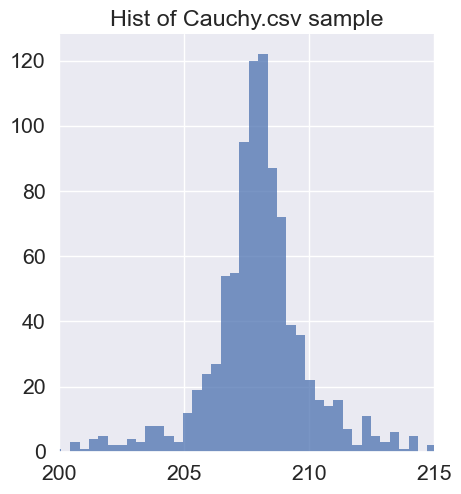

In [4]:
plt.figure(figsize=(10, 5))
sns.displot(x=cauchy_sample)
plt.xlim(200, 215)
plt.title("Hist of Cauchy.csv sample")
plt.xlabel('')
plt.ylabel('')
plt.show()

Из графика можно увидеть, что неизвестный параметр находится в пределах отрезка **[207-209]**.

3. Напишите функцию, которая находит оценку максимального правдоподобия, получив на вход выборку из распределения Коши находит максимум. Мы предполагаем, что Вы будете производить оценку по сетке --- для некоторого множества возможных параметров (отрезка с концами, которые Вам кажутся верными) постройте сетку с некоторым шагом (рекомендуется 0.01) и выберите лучший параметр на этой сетке.

Однако, если Вы хорошо поняли курс оптимизации, то напишите оптимизатор, который находит максимум сам. Задачу можно переформулировать, чтобы ответ не изменился, а оптимизация шла быстрее. За хорошо сформулированную оптимизационную задачу и реализацию мы добавим 5 бонусных баллов.

 Оцените параметр сдвига
методом максимального правдоподобия
* по первым 10 измерениям
* по первым 100 измерениям
* по всей выборке.


In [5]:
from scipy import optimize

In [6]:
def find_max(sample):
    def L_cauchy_sample(x):
        return -len(sample) * np.log(np.pi) - np.sum(np.log((sample - x)**2 + 1))
    return optimize.minimize(lambda x: -1  * L_cauchy_sample(x), x0=0).x[0]

In [7]:
print(f'Первые 10 измерений: {find_max(cauchy_sample[:10])}')
print(f'Первые 100 измерений: {find_max(cauchy_sample[:100])}')
print(f'Все измерения: {find_max(cauchy_sample)}')

Первые 10 измерений: 208.52719435963522
Первые 100 измерений: 207.8995030766694
Все измерения: 207.9782648398076


4. Изучите функцию `sps.cauchy.fit`. Как она находит параметр? Сравните полученные результаты с результатом этой функции.

In [8]:
x0, sigma = sps.cauchy.fit(cauchy_sample, method='MLE')
print(f'x_0 = {round(x0, 3)}, sigma = {round(sigma, 3)}')

x_0 = 207.978, sigma = 0.945


У `sps.cauchy.fit` по умолчанию стоит метод MLE в параметре, хотя я написал его явно. То есть он находит параметры путем максимизации логарифмической функции правдоподобия. Примерно тоже самое я сделал выше в своей реализации с помощью минимизации функции $-f(x)$. Как мы можем наблюдать, наша оценка "на глаз" из графика совпадает с вычислениями.

Вспомните задачу 3 из домашнего задания 1, где были другие оценки распределения Коши. Сделайте вывод о том, какие оценки предпочтительнее.

Там мы увидели с помощью выборочных оценок среднего, дисперсии и медианы. Там мы увидели, что наиболее предпочтительнее выглядит выорочная медиана, тоже самое можно сказать и про метод максимального правдоподобия, который тоже работает достаточно точно.

## Задача 2

Имперские банки каждую ночь подсчитывают баланс ресурсов Ордалии по сравнению с вчерашней ночью. За день приходят как новые ресурсы, так и потребляются уже имеющиеся. Как и у любого другого банка, если обозначить $X^1$ – максимальное значение баланса за день, $X^2$ – значение баланса в полночь, то $X = X^1 - X^2$ имеет распределение Вейбулла с функцией распределения $F(x) = 1 - e^{-x^\gamma} (x > 0),$ где $\gamma > 0$ –
параметр масштаба. В файле Weibull.csv находятся соответствующие измерения.

Наша задача состоит в том, чтобы оценить параметр масштаба.

In [9]:
weibull_sample = np.loadtxt("Weibull.csv")

1. Постройте гистограмму выборки. Не забудьте подобрать `xlim`, `ylim` и параметр `bins`, чтобы гистограмма была информативна.

Text(0.5, 1.0, 'Hist of Weibull.csv sample')

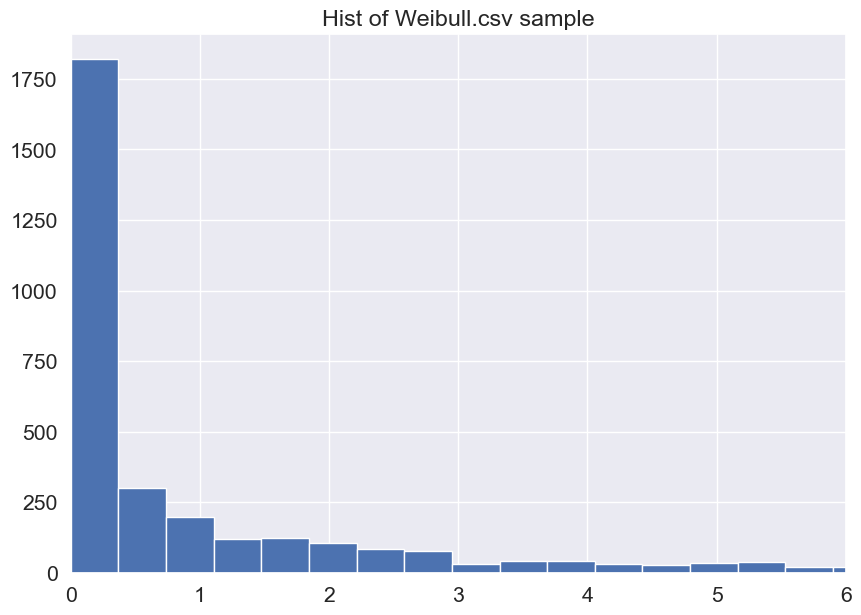

In [10]:
plt.figure(figsize=(10, 7))
plt.hist(weibull_sample, bins=1000)
plt.xlim(xmin=0, xmax=6)
plt.title('Hist of Weibull.csv sample')

Проведем небольшой предварительный анализ. Итак, если наши данные распределены согласно распределению Вейбулла, то справедливы следующие рассуждения:
$$
\begin{aligned} F(x) &=1-e^{-(x)^{\gamma}} \\-\ln (1-F(x)) &=x^{\gamma} \\ \underbrace{\ln (-\ln (1-F(x)))}_{y^{\prime}} &=\underbrace{\gamma \ln x}_{\text {kx }^{\prime}} \end{aligned}
$$
А значит и
$$
\underbrace{\ln (-\ln (1-\hat{F}(x)))}_{y^{\prime}} ≈\underbrace{\gamma \ln x}_{\text {kx }^{\prime}}
$$


Однако здесь мы сталкиваемся с проблемой: в нашей выборке есть нули. А логарифм нуля, как известно, не определен. Мы предлагаем вам придумать решение этой проблемы и обосновать его применимость. Ситуация, когда статистическая модель не описывает какие-то артефакты в данных (как, например, нули в этой задаче) для практики типична, и с ней приходится что-то делать.

Ответьте на два вопроса:
а. Могут ли нули появляться если честно семплировать из распределения Вейбулла?
б. Зная плотность распределения и то, что компьютерная точность неабсолютна, откуда нули всё-таки взялить, учитывая то, что авторы задания семплировали из распределения Вейбулла выборку?

Ответ: Тут достаточно посмотреть на плотность распределения Вейбулла:

**а)**
\begin{equation}
p(x) = F'(x) = (1 - e^{-x^\gamma})' = \gamma \cdot e^{-x^\gamma} \cdot x^{\gamma - 1}.
\end{equation}
Очевидно, что 0 в выборке появится никак не может, если делать все честно.

**б)**
Мы видим, что данные огруглены до 2-х знаков после запятой, а значит, число, котоые близкое к 0, запишется как 0. То есть любое число меньше 0.005 переходит в 0 в такой логике. Для решения проблемы можно просто убрать из выборки нулевые значения или семлировать дополнительно, используя распределение с параметром, который можно получить из оценки методом максимального правдоподобия.

2. Посчитайте эмпирическую функцию распределения и
$$y\prime = \ln (-\ln (1-\hat{F}(x))) \quad x' = ln x$$
 где $x$ – элементы исходной выборки.

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

new_sample = weibull_sample[weibull_sample != 0]
mle = sps.weibull_min.fit(new_sample, method='MLE', fscale=1, floc=0)[0]
mle_estim = sps.weibull_min.rvs(mle, size=4000)
mle_sample = np.hstack([mle_estim[mle_estim < 0.01][:507], new_sample])

ecdf = ECDF(new_sample)(new_sample)
ecdf1 = ECDF(mle_sample)(mle_sample)

new_sample = new_sample[new_sample != 1]
mle_sample = mle_sample[mle_sample != 1]
ecdf = ecdf[ecdf != 1]
ecdf1 = ecdf1[ecdf1 != 1]

y = np.log(-1 * np.log(1 - ecdf))
x = np.log(new_sample)
y1 = np.log(-1 * np.log(1 - ecdf1))
x1 = np.log(mle_sample)

**Постройте** график (`plt.scatter`) от (y', x') для Ваших способов борьбы с нулями разными цветами.
Не забудьте про `alpha=0.05` и легенду. Такой график называется `Weibull plot` и является аналогом `qqplot` для распределения Вейбулла.

(-8.0, 6.0)

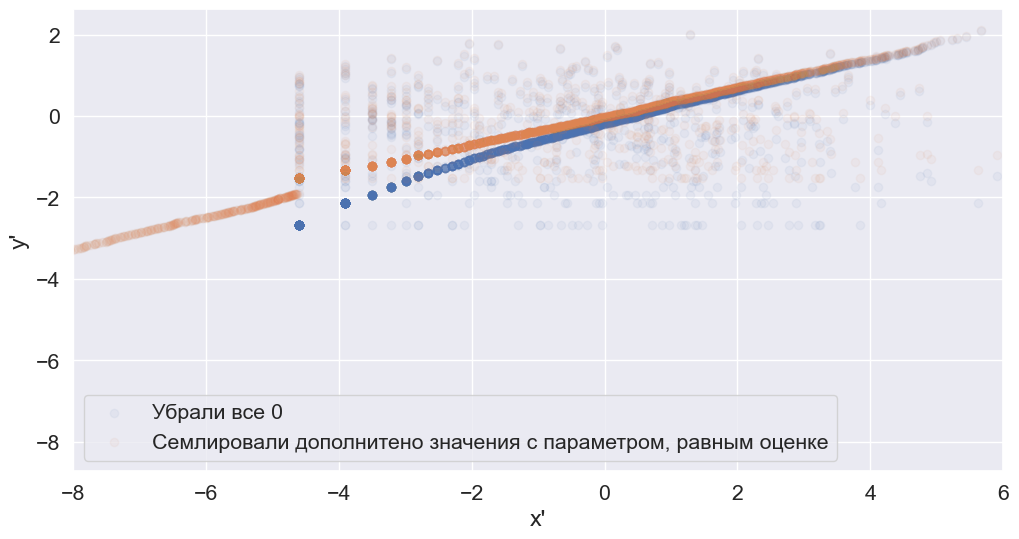

In [12]:
plt.figure(figsize = (12, 6))
plt.scatter(x, y, alpha=0.05, label="Убрали все 0")
plt.scatter(x1, y1, alpha=0.05, label="Cемлировали дополнитено значения с параметром, равным оценке")
plt.legend()
plt.xlabel("x'")
plt.ylabel("y'")
plt.xlim(-8, 6)

Сделайте вывод. Какой способ вам кажется более правильным и почему?

**Вывод:**
Конечно, метод с дополнительным семплированием с параметром из оценки, намного лучше. Просто убирая нули, мы теряем огромное кол-во информации.

3. Оцените параметр формы методом максимального правдоподобия
* по
первым 4 годам;
* по всей выборке.
Оценку произведите по сетке (в
логарифмической шкале) или оптимизатором. Известно, что $\log_{10}\gamma \in [-2, 2].$
Выберите шаг равным $10^{-3}.$

Решение:

In [13]:
gamma = sps.weibull_min.fit(mle_sample, floc=0, fscale=1, method='MLE')[0]
gamma

0.3668972493689287

Сравните результаты с `sps.weibull.fit(sample_2, fscale=1, floc=0)`

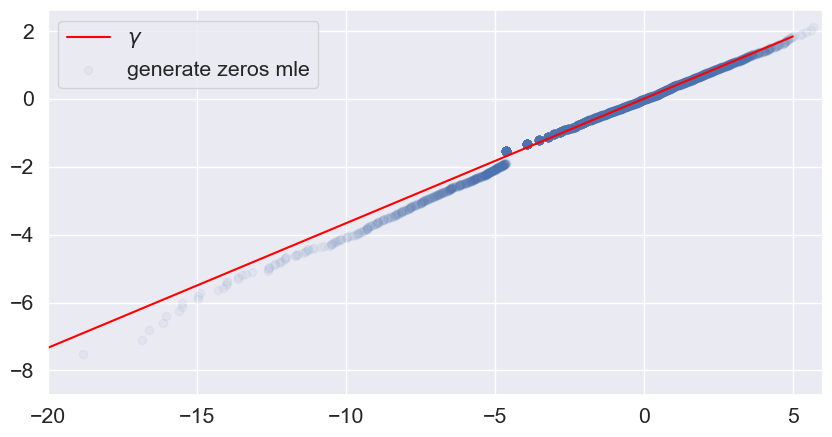

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize=(10, 5))

plt.plot(np.linspace(-20, 5), gamma * np.linspace(-20, 5), label=r"$\gamma$", color='red')

ecdf = ECDF(mle_sample)
y = np.log(-np.log(1 - ecdf(mle_sample)))
x = np.log(mle_sample)
plt.scatter(x, y, alpha=0.05, label='generate zeros mle')
plt.xlim(xmin=-20, xmax=6)
plt.legend()

 Как мы видим, точки < 5 не совсем совпадают с прямой, что не очень хорошо. Конечо, это лучше, чем просто убрать все 0.

4. Постройте график $y = \gamma \cdot x$ для всех полученных $\gamma$ (`plt.plot`) и `scatter plot` из предыдущего пункта ($y\prime \ x\prime$) для того метода, который вам кажется более правильным. Хорошо ли линии соответствуют выборке? Как вы думаете, почему?

**Вывод**

## 

## Задача 3

Хорошим методом получения аналитических оценок является метод моментов.

1. Сгенерируйте выборки $X_1, \ldots, X_N$ из $\mathit{N}(0, \theta)$, $U(0, \theta)$, $\Gamma(1, \theta)$ (**параметризация $k, \theta$**), $\theta = 3$ для всех распределений $(N = 1000).$ Посчитайте значения оценок (по выборке $X_1, \ldots X_n$) методом моментов. Промоделируйте полученные оценки для разных размеров выборки $n < N$ и изучите их скорости сходимости. На графике отразите истинный параметр. Можете построить отдельный график модуля/квадрата разности оценки и параметра (риск) для какой-то выборке и посмотреть, как быстро риск сходится к нулю.

Решение (вывод метода моментов для каждого случая):

In [34]:
def moment1(X):
    return np.cumsum(X) / np.array(range(1, 1 + X.shape[0]))

def moment2(X):
    return np.cumsum(X**2) / np.array(range(1, 1 + X.shape[0])) 

In [35]:
N = 1000
theta = 3

In [36]:
X_norm = sps.norm(loc = 0, scale = np.sqrt(theta)).rvs(N)
X_uniform = sps.uniform(0, theta).rvs(N)
X_gamma = sps.gamma(a = 1, loc = 0, scale = theta).rvs(N)

In [37]:
res_dict = {
    'norm': np.abs(moment2(X_norm) - theta),
    'uniform': np.abs(2 * moment1(X_uniform) - theta),
    'gamma': np.abs(moment1(X_gamma) - theta)
}

Text(0.5, 1.0, 'Зависимость $|\\theta - \\hat\\theta|$ от размера выборки')

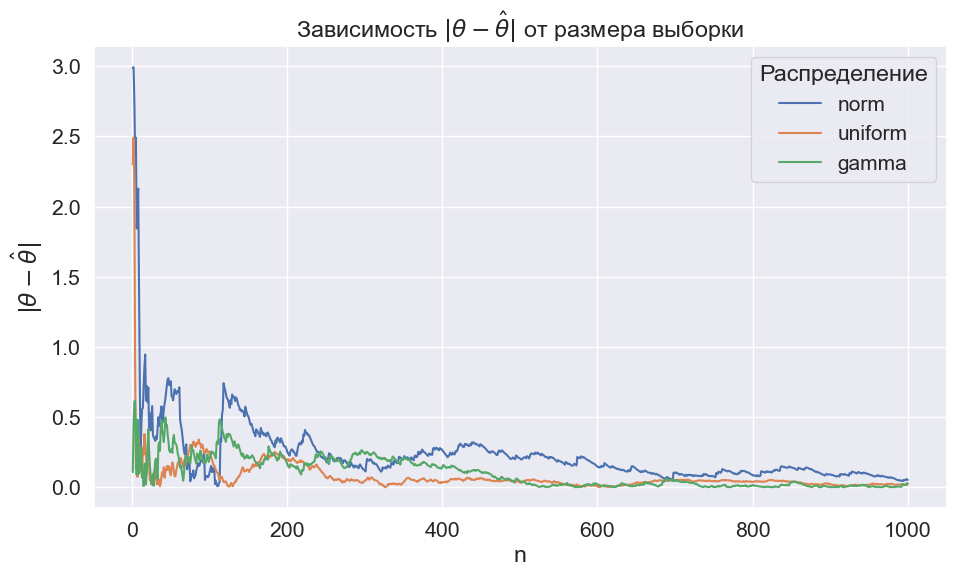

In [38]:
grid = range(1, N + 1)

plt.figure(figsize=(11, 6))
for item in res_dict:
    plt.plot(grid, res_dict[item], label = item)
plt.legend(title='Распределение', fontsize=15)
plt.xlabel('n')
plt.ylabel(r'$|\theta - \hat\theta|$')
plt.title(r'Зависимость $|\theta - \hat\theta|$ от размера выборки')

2. Есть два замечательных распределения, которые игнорировать никак нельзя. Первое --- $Pareto(k)$ с плотностью $p(x) = kx^{-k-1}$ ($k$ произвольное), $Cauchy(0, \theta)$  с плотностью $p(x) = \frac{\theta}{x^2 + \theta^2}$. Запишите оценки методом моментов для них и проверьте их на состоятельность на практике (моделированием). Подсказка: внимательно изучите, чему равны моменты каждого из распределений и при каких условиях. Можно ли гарантировать состоятельность полученных оценок каким-то теоретическими фактами?

Решение (аналитический вывод оценок):

In [20]:
pareto = sps.pareto.rvs(size = N, b=theta)
cauchy = sps.cauchy.rvs(size=N, scale=theta)

In [21]:
sps.pareto.fit(pareto, fscale=1, floc=0)

(2.9226320202784772, 0, 1)

In [22]:
sps.cauchy.fit(cauchy, floc=0)

(0, 2.7967521984705486)

Моделирование:

**Вывод:**

**Следующие две задачи посвящены тому, как получать более информативные оценки, чем точечные. Нам приходится обращаться к ним, так как свойства точечных оценок являются предельными, и мы мало что знаем о том, насколько конкретное значение оценки близко к истинному значению параметра. В условиях кровавой войны информация должна быть максимальной.**

### Задача 4. Бутстреп

Для реальных данных часто сложно подобрать распределение и нужную параметризацию относительно $\theta$. Кроме того на практике сложно посчитать дисперсию оценки (для этого хотя бы нужно знать распределение, из которого пришла выборка) и какой-то отрезок, в который параметр попадёт с высокой вероятностью (такой отрезок называется **доверительным интервалом**_. На помощь в таких случаях приходит **бутстреп**.

Идея очень простая. Вспомним, как работает **метод подстановки** для получения оценок. В нём мы выражаем параметр при помощи распределения (как среднее или медиана, например), потом меняем распределение на эмпирическое и выражаем параметр уже через него. Бутстреп это подмена истинного распределения на эмпирическое.



1. Для каждого распределения из задачи 3 сгенерируйте выборку размера $N = 1000$. Далее замените Ваше распределение на равномерное распределение по построенной выборке (по теореме Гливенко-Кантелли эти распределения достаточно близки), и из эмпирического (равномерного) распределения постройте 100 выборок. Опишите, как Вы будете это делать. Указание: из истинного распределения (нормального и т.д.) новые данные генерировать **нельзя**. Бутстреп это способ получения псевдо-новых данных из уже имеющихся.

Ответ:

In [23]:
def bootstrap_generate_func(sample):
    return np.random.choice(sample, (100, N))

In [24]:
N = 1000
theta = 3

In [25]:
X_norm = sps.norm(loc = 0, scale = np.sqrt(theta)).rvs(N)
X_uniform = sps.uniform(0, theta).rvs(N)
X_gamma = sps.gamma(a = 1, loc = 0, scale = theta).rvs(N)

In [26]:
norm_bs = bootstrap_generate_func(X_norm)
uniform_bs = bootstrap_generate_func(X_uniform)
gamma_bs = bootstrap_generate_func(X_gamma)

2. Для каждой псевдо-выборки из предыдущего пункта постройте оценку методом моментов из задачи 3 и получится выборка оценок (как в домашке 1). По ней посчитайте эмпирическую (выборочную) дисперсию оценок и сделайте вывод о том, как связано значение дисперсии оценки (теоретической и бутстрепной) с точностью и скоростью сходимости оценки к параметру.

In [29]:
est_norm = np.square(norm_bs).mean(axis=1)
est_uniform = 2 * uniform_bs.mean(axis=1)
est_gamma = gamma_bs.mean(axis=1)

In [30]:
def dispersion_est(arr_esimates):
    return np.mean(np.abs(np.mean(arr_esimates) - arr_esimates)**2)

In [33]:
print(f'Выборочная дисперсия norm_distribution {dispersion_est(est_norm)}')
print(f'Выборочная дисперсия uniform_distribution {dispersion_est(est_uniform)}')
print(f'Выборочная дисперсия gamma_distribution {dispersion_est(est_gamma)}')

Выборочная дисперсия norm_distribution 0.02029254466344269
Выборочная дисперсия uniform_distribution 0.0028726385912516885
Выборочная дисперсия gamma_distribution 0.008782965547576002


По данным, которые мы сейчас получили, можно сделать предположение, что чем меньше выборочная дисперсия нашей оценки, полученной бустрепом, тем быстрее будет сходится оценка к иснному значению параметра. По крайне мере, это явино видно, если сравнить norm_distribution и gamma_distribution и посмореть на график выше из предыдущей задачи.

3. Бутстрепным доверительным интервалом порядка $\alpha$ называется отрезок $[\theta_{\frac{\alpha}{2}}, \theta_{\frac{1 - \alpha}{2}}]$, где $theta_{\alpha}$ это выборочный $\alpha$-квантиль из распределения оценок, построенного в задаче методом бутстрепа. Опишите, как такой выборочный квантиль связан с истинным квантилем распределения оценок и каким свойством обладал бы построенный отрезок, если бы мы его строили не эмпирически, а точно (с настоящими квантилями). Постройте доверительный интервал численно для разных значений параметра и изучите, часто ли параметр в него попадает.

**Вывод:**

### Задача 5. Байес.

**Эта задача стоит 20 баллов**

Байесовское оценивание даёт ультиматимативный способ построения оценок без какой-либо потери в информации. Теперь мы оцениваем параметры распределения не точками и не отрезками, а распределениями!

1. Будем смотреть на параметрическое семейство распределений как на условное распределение: $P_{\theta} = P(X | \theta)$. В байесовском подходе подразумевается, что параметр $\theta$ сам приходит из некоторого **априорного** распределения (которое статист либо предпологает сам, либо предпологает исходя из внешних знаний об области).

Вспомним теорему Байеса: $p(\theta | X) = \frac{p(X | \theta) p(\theta)}{p(X)}$, где знаменатель $p(x)$ получается как интеграл по $\theta$ от числителя. В зависимости от того, можем ли мы взять этот интеграл, выбирается тип байесовской оценки. $p(X | \theta)$ мы знаем, это хорошо нам знакомое правдоподобие, $p(\theta)$ называется априорным распределением (prior) параметра, мы его выбираем сами исходя из наших предпочтений, $p(X)$ от параметра не зависит и называется обоснованностью (evidence), и показывает, насколько правдоподобна выборка в терминах выбранного семейства распределений.

Для первого пункта задачи выберите некоторое нетривиальное значение параметра для двух распределений: $Bern(p)$, $Exp(\lambda)$ и сгенерируйте по одной выборке размера $N = 1000$.

2. "Байес для бедных" (Poor man's bayes)

Пусть интеграл в знаменателе мы считать не умеем и мы готовы с этим смириться. Что в таком случае делать? Можно искать моду (максимум) апостериорной плотности $P(\theta | X)$, где $X$ --- выборка, и рассматривать оценку $\theta$ как точку максимума.

Подберите три различных априорных распределения на параметр и найдите максимум апостериорной плотности.
Преобразуйте задачу максимизации и найдите максимум по сетке или оптимизатором.

Сделайте вывод о том, как влияет априорная информация о параметре на оценку? Вспомните лекции из курса машинного обучения. На какой объект похоже априорное распределение? Как его следует выбирать. Как связаны максимум апостериорной плотности и оценка максимального правоподобия?

3. Байес для богатых (обычный байес).

Отказываться считать интеграл нельзя, за это полагается смертная казнь.

Проверьте, что для распределения Бернулли можно взять априорное распределение в виде бета распределения $Beta(1, 1)$ и тогда апостериорная плотность будет также принадлежать семейству бета распределений. Какие параметры будут у апостериорной плотности?

Решение:

Рассуждение выше означает, что интеграл можно не считать, так как он будет известен исходя из того, что апостериорное распределение будет принадлежать семейству бета распределений. А найденные параметры бета распределения и будут хорошим приближением параметра. По выборке из распределения Бернулли посчитайте параметры апостериорной плотности и изобразите её плотность на графике.

Что Вы бы брали точечной оценкой параметра исходя из апостериорного распределения? Почему?

Как апостериорное распределение изменяется при разных параметрах априорного бета-распределения? Как выбирать эти параметры на практике? Какой смысл они несут? Снова вспомните лекции из курса машинного обучения.

Такие пары распределений называются **сопряжёнными**. Для сопряжённых распределений верно, что после применения теоремы Байеса апостериорная плотность лежит в том же параметрическом семействе, что и априорная.

Для экспоненциального распределения сопряжённым является Гамма-распределение.

Проделайте для экспоненциального распределения ту же работу, что и для Бернулли.

Сделайте вывод о байесовском оценивании: